### Importing packages

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import skimage
#from skimage import data
from skimage import filters
#import scipy
#from scipy import ndimage
#from scipy import misc
#import imageio as io
#import copy
#from skimage import morphology
#from skimage import exposure
#from skimage.morphology import erosion, dilation, opening
import czifile as cz
#import warnings
#from IPython.display import Image
#import random
#from tqdm.notebook import tqdm

#import imutils
import cv2
#from scipy import signal

#import pickle
#from skimage import img_as_ubyte
import pandas as pd
from skimage.morphology import (erosion, dilation, opening, closing,  # noqa
                                white_tophat,disk)
import copy

## Defining helper functions


In [5]:
def open_2d_czi(path):
    with cz.CziFile(path) as cz_obj:
        return np.squeeze(cz_obj.asarray())
    
def plot_large(image,cmap = 'gray'):
    plt.figure(figsize = [16,20])
    plt.imshow(image,cmap)
    
def norm_im(im):
    im_norm = (im - im.min()) / (im.max() - im.min())
    return im_norm

def local_gausian_thresh(im,block_size):
    thresh_val = filters.threshold_local(im,
                                         block_size = block_size,
                                         method='gaussian',
                                         offset=0,
                                         mode='reflect')
    thresh_im = im < thresh_val
    return np.array(thresh_im,dtype = np.uint8)

def err_dil(im,disk_size = 3):
    footprint = disk(disk_size)
    eroded = erosion(im, footprint)
    dialated = dilation(eroded, footprint)
    return dialated

def label_objs(image):
    lab_im, num_obj = skimage.measure.label(image, return_num=True)
    #lab_rand_image = randomize_labels(lab_im)
    return lab_im,num_obj#,lab_rand_image

def randomize_labels(im_lab):
    lab_dict = {i:np.random.randint(0,int(np.max(im_lab))+1) for i in range(1,int(np.max(im_lab))+1)}
    lab_dict[0] = 0
    im_lab_rand = np.zeros(im_lab.shape)
    for i in range(im_lab.shape[0]):
        for j in range(im_lab.shape[1]):
            im_lab_rand[i,j] = lab_dict[im_lab[i,j]]
    #plt.figure(figsize = [2*6.4, 2*4.8])
    #plt.imshow(im_lab_rand,'jet')
    return im_lab_rand


def filterCells(lab_im,num_obj,maxP,minP):
    accepted_obj_nums = []
    obj_areas = []
    im_lab_accept = np.zeros(lab_im.shape)
    for obj in range(num_obj):
        cell = lab_im == obj
        area = np.sum(cell)
        obj_areas.append(area)
        if area < maxP and area > minP:
            accepted_obj_nums.append(obj)
            im_lab_accept += cell*obj
    return accepted_obj_nums,im_lab_accept,obj_areas

def fit_ellipse(im_lab_accept,obj_num):
    bin_obj_im = np.array(im_lab_accept==obj_num,dtype = np.uint8)
    contours,hierarchy = cv2.findContours(bin_obj_im, 2, 1) ######### params for find contours are very important
    ### param 1 is the method, param 2 is the approximation
    ## currently using 2 = cv.RETR_CCOMP and 1= cv.CHAIN_APPROX_SIMPLE
    ## using method 1 and approx 2, ye
    contour = contours[0]
    #print(obj_num,contour)
    if len(contour)<5:
        return None,bin_obj_im,contour
    # Fit an ellipse to the contour
    ellipse = cv2.fitEllipse(contour)
    # ellipse is a tuple of ((centerCols,centerRows),(widthCols,heightRows),rotation)
    # ^^rows and cols might be swapped above, idk
    return ellipse,bin_obj_im,contour

def rect_in_window(rect, window_shape):
    center_x, center_y = rect[0]
    width, height = rect[1]
    x_min, y_min = center_x - width / 2, center_y - height / 2
    x_max, y_max = center_x + width / 2, center_y + height / 2
    window_height, window_width = window_shape
    
    # Get the four vertices of the rectangle
    vertices = np.array([[x_min, y_min], [x_min, y_max], [x_max, y_max], [x_max, y_min]])
    
    # Rotate the vertices around the center of the rectangle
    theta = np.deg2rad(rect[2])
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    vertices = np.matmul(vertices - np.array([center_x, center_y]), rotation_matrix) + np.array([center_x, center_y])
    
    # Check if all vertices are within the window
    return (vertices[:,0] >= 0).all() and (vertices[:,1] >= 0).all() and (vertices[:,0] <= window_width).all() and (vertices[:,1] <= window_height).all()

#Forgot how exactly it works, but it works!
def translateRotation(rotation, width, height):
    if (width < height):
        rotation = -1 * (rotation - 90)
    if (rotation > 90):
        rotation = -1 * (rotation - 180)
    rotation *= -1
    return round(rotation)

def get_ellipse_prop(ellipse):
    """need to double check if the length is computed correctly"""
    centerE = ellipse[0]
    # Gets width and height of rotated ellipse
    widthE = ellipse[1][0]
    heightE = ellipse[1][1]
    # Gets rotation of ellipse; same as rotation of contour
    rotation = ellipse[2]
    rot90 = translateRotation(rotation, widthE, heightE)
    
    if widthE>heightE:
        length = widthE
        ratio = widthE/heightE
    else:
        length = heightE
        ratio = heightE/widthE
    return centerE, length, ratio, rot90

def ellipse_img(ellipse,window_shape):
    ellipse_image = np.zeros(window_shape)
    #im = cv2.ellipse(ellipse_image, ellipse, (0, 255, 0), -1)
    return cv2.ellipse(ellipse_image, ellipse, (255, 0, 0), 1)

def draw_arrow2(center, length, angle, window_size):
    length/=2
    angle = np.deg2rad(angle)
    # Create a black image of the specified shape
    image = np.zeros(window_size, dtype=np.uint8)

    # Calculate the starting and ending points of the arrow
    start = center
    end = [center[0] + length * np.cos(angle), center[1] + length * np.sin(angle)]

    # Get the x and y coordinates of the arrow
    x = np.linspace(start[0], end[0], num=100, dtype=np.int32)
    y = np.linspace(start[1], end[1], num=100, dtype=np.int32)

    # Set the pixels of the arrow to 1
    image[y, x] = 1

    return image



## Defineing the whole processing method

In [22]:
def process_file_v2(image_metadata,params,return_images = True):
    """ This function runs the whole image processing procedure:
    PARAMETERS
    -----------------------------------------------------------------------------------
    image_metadata:
    - dictionary that includes filename, datapath, condition, flow, time, cell_age, date
        ex: {'file_name': 'HCAEC_12 hr DF_P7_heparin 2 UmL_1_21523.czi',
             'data_path': 'ron_data/Heparin Treated/2.15.23',
             'treatment': 'heparin 2 UmL',
             'flow': 'DF',
             'time': '12 hr',
             'cell_age': 'P7',
             'date': 21523}
    Params:
    -The image processing parameters dictionary
        ex: {
         'thresh_block' : 101,
         'err_dil_disk' : 3,
         'max_cell_size' : 1000,
         'min_cell_size' : 50
         }
    CODE DESCRIPTION
    ------------------------------------------------------------------------------------
    part 1:    
    1) open image as array *rotate the image 90 degrees*, 2) normalize pixel values(0-1), 3) local gausian threshold, 
    4) errode then dialate to remove specks, 5)identify objects and label them, 6)filter objects by min/max size
    ---> result is an image with pixel values representing the object that they belong to. 
    
    part 2:
    1) creates a dataframe to store data about each cell.
    2) for each object in the labled image rom part 1, if object is not at the image border, 
        create a contour around it and fit an ellipse shape around it and record the properties of this ellipse into the df
    ---> result is a pandas DataFrame with rows being each cell detected, and 
        cols: file name, condition, object number, obj area, ellipse properties (for drawring purpose), 
        ellipse center, length in long direction, ellipse aspect ratio, cell orientation angle -90to90degrees
        
    part 3:
    1) create an image of all the elipses that were fit
    2) create an image of lines each going from the center of ellipse to the right hand side long pole of the ellipse
        this is essentiall a line pointing in the cell orientation direction
    3) create an RGB image with gray scaled original phase image, red ellipses, blue direction lines
    
    RETURNS
    -------------------------------------------------------------------------------------
    Returns a tuple with:
    1) the Data Frame
    2) the color image from part 3
    3) an image stack with the intermediate processing steps:
        n_im,thresh_im,erdil_im,lab_im,im_lab_accept,accept_elipses,elipse_arrows
    """
    
    """part 1:"""
    path = os.path.join(image_metadata['data_path'],image_metadata['file_name'])
    im = open_2d_czi(path) #rotated 90 so that flow goes in orientation direction measurement. 
    # Alternative is the change the rotationtranslation to be 0-180 instead of -90to90
    n_im = norm_im(im)
    thresh_im = local_gausian_thresh(n_im,params['thresh_block'])
    erdil_im = err_dil(thresh_im,disk_size = params['err_dil_disk'])
    lab_im,num_obj = label_objs(erdil_im)
    accepted_obj_nums,im_lab_accept,obj_areas = filterCells(lab_im,num_obj,params['max_cell_size'],params['min_cell_size'])

    
    '''part 2:'''
    """create the DF to store all the ellipse data from all files, then for each accepted object fit an ellipse, and ellipse properties to df"""
    
    columns = []
    df = pd.DataFrame(columns=columns)
    """populate in the dataframe with the properties of each cell identified and fit with ellipse"""
    ellipse_rejects = []
    contour_rejects = []
    for i,obj_num in enumerate(accepted_obj_nums):
        ellipse,_,contour = fit_ellipse(im_lab_accept,obj_num)
        if ellipse is not None:
            if rect_in_window(ellipse,im_lab_accept.shape):
                center, length, ratio, rot90 = get_ellipse_prop(ellipse)
                area = obj_areas[obj_num]
                #obj_num,area,ellipse,center,length, ratio, rot90]
                obj_data = copy.deepcopy(image_metadata)
                obj_data['obj_num'] = obj_num
                obj_data['area'] = area
                obj_data['ellipse'] = ellipse
                obj_data['center'] = center
                obj_data['length'] = length
                obj_data['ratio'] = ratio
                obj_data['rot90'] = rot90
                for key, value in obj_data.items():
                    if key not in df.columns:
                        df[key] = pd.Series(dtype=object)
                df.loc[len(df)] = obj_data
                #df.loc[len(df)] = [params['f_name'],params['condition'],obj_num,area,ellipse,center,length, ratio, rot90]
                
        else:
            ellipse_rejects.append(obj_num)
            contour_rejects.append(contour)
    
    
    '''Part 3:'''
    """ create an image with the red ellipses using the ellipse data from the DF"""
    if return_images:
        accept_elipses = np.zeros((im_lab_accept.shape))
        for i in range(len(df)):
            e = df['ellipse'][i]
            accept_elipses += ellipse_img(e,im_lab_accept.shape)
        """ create an image with blue lines in the direction of the long elipse axis from the ellipse data from the DF"""
        elipse_arrows_long = np.zeros((im_lab_accept.shape))
        elipse_arrows_short = np.zeros((im_lab_accept.shape))
        for i in range(len(df)):
            if df['ratio'][i]>=2:
                elipse_arrows_long+=draw_arrow2(df['ellipse'][i][0], df['length'][i],df['rot90'][i] , im_lab_accept.shape)
            else:
                elipse_arrows_short+=draw_arrow2(df['ellipse'][i][0], df['length'][i],df['rot90'][i] , im_lab_accept.shape)
        elipse_arrows = elipse_arrows_long+elipse_arrows_short
        """ create a color image composit of the gray scale phase image, red elipses and blue direction lines"""
        color_image2 = np.dstack([n_im, n_im, n_im])
        color_image2[accept_elipses>0, 0] = 1
        color_image2[accept_elipses>0, 1:] = 0
        color_image2[elipse_arrows_long>0, 2] = 1
        color_image2[elipse_arrows_long>0, :2] = 0
        color_image2[elipse_arrows_short>0, 1] = 1
        color_image2[elipse_arrows_short>0, :1] = 0
        color_image2[elipse_arrows_short>0, 2] = 0
        proceesing_stack = np.transpose(np.dstack([n_im,thresh_im,erdil_im,lab_im,
                                            im_lab_accept,accept_elipses,elipse_arrows]), (2, 0, 1))
    else:
        color_image2,proceesing_stack = None,None
    
    return df,color_image2,proceesing_stack

    ### save the DF
    #df.to_csv('ron_ellipse_data_v2'+params['f_name']+r'.csv')

    ### save the intermediate and final images

## Run the proceesing for each file and combine the data for eahc experiment

In [7]:
meta_data = pd.read_csv('Ron_Cell_Alignment_metadata_9_20_23.csv')
meta_data

exp_num                                          file_name  \
0         0           HCAEC P8_12 hr UF_No Treatment_51023.czi   
1         1           HCAEC P8_12 hr DF_No Treatment_51023.czi   
2         2       HCAEC P8_12 hr Static_No Treatment_51023.czi   
3         3            HCAEC P7_12 hr DF_No Treatment_5823.czi   
4         4        HCAEC P7_12 hr Static_No Treatment_5823.czi   
5         5            HCAEC P7_12 hr UF_No Treatment_5823.czi   
6         6       HCAEC P8_12 hr Static_No Treatment_51823.czi   
7         7           HCAEC P8_12 hr UF_No Treatment_51823.czi   
8         8           HCAEC P8_12 hr DF_No Treatment_51823.czi   
9         9            HCAEC P7_12 hr UF_No Treatment_5223.czi   
10       10            HCAEC P7_12 hr DF_No Treatment_5223.czi   
11       11        HCAEC P7_12 hr Static_No Treatment_5223.czi   
12       12            HCAEC P7_12 hr UF_No Treatment_5323.czi   
13       13            HCAEC P7_12 hr DF_No Treatment_5323.czi   
14       14        HCAEC P7_12 hr Static_No Treatment_5323.czi   
15       15          HCAEC_12 hr UF_P7_Heparin 2 UmL_32423.czi   
16       16      HCAEC_12 hr Static_P7_Heparin 2 UmL_32423.czi   
17       17          HCAEC_12 hr DF_P7_Heparin 2 UmL_32423.czi   
18       18          HCAEC P8_12 hr DF_Heparin 2 UmL_13023.czi   
19       19          HCAEC P8_12 hr UF_Heparin 2 UmL_13023.czi   
20       20      HCAEC_12 hr Static_P8_Heparin 2 UmL_13023.czi   
21       21        HCAEC_12 hr DF_P7_Heparin 2 UmL_1_21523.czi   
22       22    HCAEC_12 hr Static_P7_Heparin 2 UmL_1_21523.czi   
23       23        HCAEC_12 hr UF_P7_Heparin 2 UmL_1_21523.czi   
24       24       HCAEC_12 hr Static_P5_Heparin 2 UmL_2723.czi   
25       25           HCAEC_12 hr UF_P5_Heparin 2 UmL_2723.czi   
26       26           HCAEC_12 hr DF_P5_Heparin 2 UmL_2723.czi   
27       27          HCAEC_12 hr UF_P8_Heparin 2 UmL_32623.czi   
28       28      HCAEC_12 hr Static_P8_Heparin 2 UmL_32623.czi   
29       29          HCAEC_12 hr DF_P8_Heparin 2 UmL_32623.czi   
30       30  HCAEC_12 hr Static_P7_Albumin bound S1P_22423.czi   
31       31      HCAEC_12 hr UF_P7_Albumin bound S1P_22423.czi   
32       32      HCAEC_12 hr DF_P7_Albumin bound S1P_22423.czi   
33       33      HCAEC_12 hr UF_P8_Albumin bound S1P_41323.czi   
34       34  HCAEC_12 hr Static_P8_Albumin bound S1P_41323.czi   
35       35      HCAEC_12 hr DF_P8_Albumin bound S1P_41323.czi   
36       36  HCAEC_12 hr Static_P6_Albumin bound S1P_22223.czi   
37       37      HCAEC_12 hr UF_P6_Albumin bound S1P_22223.czi   
38       38      HCAEC_12 hr DF_P6_Albumin bound S1P_22223.czi   
39       39  HCAEC_12 hr Static_P7_Albumin bound S1P_41223.czi   
40       40      HCAEC_12 hr UF_P7_Albumin bound S1P_41223.czi   
41       41      HCAEC_12 hr DF_P7_Albumin bound S1P_41223.czi   
42       42  HCAEC_12 hr Static_P6_Albumin bound S1P_22323.czi   
43       43      HCAEC_12 hr UF_P6_Albumin bound S1P_22323.czi   
44       44      HCAEC_12 hr DF_P6_Albumin bound S1P_22323.czi   
45       45      HCAEC_12 hr UF_P8_Albumin bound S1P_21823.czi   
46       46  HCAEC_12 hr Static_P8_Albumin bound S1P_21823.czi   
47       47      HCAEC_12 hr DF_P8_Albumin bound S1P_21823.czi   
48       48  HCAEC P6_12 hr UF_Heparin S1P Treatment_31423.czi   
49       49  HCAEC P6_12 hr DF_Heparin S1P Treatment_31423.czi   
50       50  HCAEC P6_12 hr Static_Heparin S1P Treatment_31...   
51       51  HCAEC P7_12 hr UF_Heparin S1P Treatment_31823.czi   
52       52  HCAEC P7_12 hr DF_Heparin S1P Treatment_31823.czi   
53       53  HCAEC P7_12 hr Static_Heparin S1P Treatment_31...   
54       54  HCAEC P5_12 hr UF_Heparin S1P Treatment_41923.czi   
55       55  HCAEC P5_12 hr Static_Heparin S1P Treatment_41...   
56       56  HCAEC P5_12 hr DF_Heparin S1P Treatment_41923.czi   
57       57  HCAEC P6_12 hr UF_Heparin S1P Treatment_31723.czi   
58       58  HCAEC P6_12 hr Static_Heparin S1P Treatment_31...   
59       59  HCAEC P6_12 hr DF_Heparin S1P T

In [8]:
group_mapping = {}
for _, row in meta_data.drop_duplicates(['treatment', 'flow']).iterrows():
    group_number = row['group']
    string_combination = (row['treatment'], row['flow'])
    group_mapping[group_number] = string_combination

print(group_mapping)

{11: ('No Treatment', 'UF'), 9: ('No Treatment', 'DF'), 10: ('No Treatment', 'Static'), 5: ('Heparin 2 UmL', 'UF'), 4: ('Heparin 2 UmL', 'Static'), 3: ('Heparin 2 UmL', 'DF'), 1: ('Albumin bound S1P', 'Static'), 2: ('Albumin bound S1P', 'UF'), 0: ('Albumin bound S1P', 'DF'), 8: ('Heparin S1P', 'UF'), 6: ('Heparin S1P', 'DF'), 7: ('Heparin S1P', 'Static')}


In [9]:
# meta_data.loc[0].to_dict()

In [10]:
# f1_meta = meta_data.iloc[0].to_dict()
# f1_params = {'thresh_block' : 101,
#              'err_dil_disk' : 3,
#              'max_cell_size' : 1500,
#              'min_cell_size' : 100
#          }

In [11]:
# f1_data = process_file_v2(f1_meta,f1_params)

In [12]:
#f1_data[0]

In [13]:
# np.sum(f1_data[0]['ratio']>2)

# f1_data[0].to_csv('test_f1_df.csv',index = False)

In [14]:
# f1_meta = meta_data.iloc[0].to_dict()
# f1_params = {'thresh_block' : 101,
#              'err_dil_disk' : 3,
#              'max_cell_size' : 1500,
#              'min_cell_size' : 100
#          }

# f1_data = process_file_v2(f1_meta,f1_params)



In [15]:
# f1_data[0]['elong2'] = f1_data[0]['ratio']>2
# f1_data[0]['rot90_bar'] = np.mean(f1_data[0]['rot90'][f1_data[0]['elong2']])
# f1_data[0]['rot90_bar_all'] = np.mean(f1_data[0]['rot90'])
# f1_data[0]['oop_bar'] = 2*np.cos(np.deg2rad(f1_data[0]['rot90']-f1_data[0]['rot90_bar']))**2-1
# f1_data[0]['oop_zero'] = 2*np.cos(np.deg2rad(f1_data[0]['rot90']))**2-1

# f1_data[0]


# run batch processing

In [3]:
def get_oop(exp_data):
    exp_data['elong2'] = exp_data['ratio']>2
    exp_data['rot90_bar'] = np.mean(exp_data['rot90'][exp_data['elong2']])
    exp_data['rot90_bar_all'] = np.mean(exp_data['rot90'])
    exp_data['oop_bar'] = 2*np.cos(np.deg2rad(exp_data['rot90']-exp_data['rot90_bar']))**2-1
    exp_data['oop_zero'] = 2*np.cos(np.deg2rad(exp_data['rot90']))**2-1
    return exp_data

    

def batch_process(meta_data_df,parms):
    master_df = pd.DataFrame()
    for i in range(len(meta_data_df)):
        exp_meta_dict = meta_data_df.iloc[i].to_dict()
        exp_data,_,_ = process_file_v2(exp_meta_dict,params,return_images=False)
        master_df = pd.concat([master_df, get_oop(exp_data)], axis=0,ignore_index = True)
        print(f'processed {i}/{len(meta_data_df)}')
    return master_df


params = {'thresh_block' : 101,
             'err_dil_disk' : 3,
             'max_cell_size' : 1500,
             'min_cell_size' : 100
         }
meta_data_df = pd.read_csv('Ron_Cell_Alignment_metadata_9_20_23.csv')

master_df = batch_process(meta_data_df,params)


NameError: name 'pd' is not defined

In [8]:
master_df.to_csv('Ron_Cell_Alignment_MasterDF_9_20_23.csv')

oop distribution for 

In [7]:
master_df

exp_num                                          file_name  \
0            0           HCAEC P8_12 hr UF_No Treatment_51023.czi   
1            0           HCAEC P8_12 hr UF_No Treatment_51023.czi   
2            0           HCAEC P8_12 hr UF_No Treatment_51023.czi   
3            0           HCAEC P8_12 hr UF_No Treatment_51023.czi   
4            0           HCAEC P8_12 hr UF_No Treatment_51023.czi   
...        ...                                                ...   
75137       59  HCAEC P6_12 hr DF_Heparin S1P Treatment_31723.czi   
75138       59  HCAEC P6_12 hr DF_Heparin S1P Treatment_31723.czi   
75139       59  HCAEC P6_12 hr DF_Heparin S1P Treatment_31723.czi   
75140       59  HCAEC P6_12 hr DF_Heparin S1P Treatment_31723.czi   
75141       59  HCAEC P6_12 hr DF_Heparin S1P Treatment_31723.czi   

                                               data_path     treatment flow  \
0                    Cell Alignment/No Treatment/5.10.23  No Treatment   UF   
1                    Cell Alignment/No Treatment/5.10.23  No Treatment   UF   
2                    Cell Alignment/No Treatment/5.10.23  No Treatment   UF   
3                    Cell Alignment/No Treatment/5.10.23  No Treatment   UF   
4                    Cell Alignment/No Treatment/5.10.23  No Treatment   UF   
...                                                  ...           ...  ...   
75137  Cell Alignment/Heparin + Albumin bound S1P/3.1...   Heparin S1P   DF   
75138  Cell Alignment/Heparin + Albumin bound S1P/3.1...   Heparin S1P   DF   
75139  Cell Alignment/Heparin + Albumin bound S1P/3.1...   Heparin S1P   DF   
75140  Cell Alignment/Heparin + Albumin bound S1P/3.1...   Heparin S1P   DF   
75141  Cell Alignment/Heparin + Albumin bound S1P/3.1...   Heparin S1P   DF   

        time cell_age   date  group  replicate  ...  \
0      12 hr       P8  51023     11          1  ...   
1      12 hr       P8  51023     11          1  ...   
2      12 hr       P8  51023     11          1  ...   
3      12 hr       P8  51023     11          1  ...   
4      12 hr       P8  51023     11          1  ...   
...      ...      ...    ...    ...        ...  ...   
75137  12 hr       P6  31723      6          2  ...   
75138  12 hr       P6  31723      6          2  ...   
75139  12 hr       P6  31723      6          2  ...   
75140  12 hr       P6  31723      6          2  ...   
75141  12 hr       P6  31723      6          2  ...   

                                                 ellipse  \
0      ((223.56651306152344, 8.397920608520508), (11....   
1      ((314.193115234375, 7.629621505737305), (11.64...   
2      ((399.5618591308594, 14.099471092224121), (14....   
3      ((1163.43115234375, 9.578180313110352), (11.95...   
4      ((650.6412963867188, 10.803470611572266), (9.9...   
...                                                  ...   
75137  ((521.1942749023438, 1019.0352783203125), (11....   
75138  ((101.09074401855469, 1022.1510620117188), (9....   
75139  ((292.6744079589844, 1017.7178344726562), (8.1...   
75140  ((164.10572814941406, 1020.1190795898438), (9....   
75141  ((63.74483108520508, 1025.0799560546875), (14....   

                                         center     length     ratio  rot90  \
0       (223.56651306152344, 8.397920608520508)  12.488817  1.061339     82   
1         (314.193115234375, 7.629621505737305)  35.056408  3.009146     -2   
2       (399.5618591308594, 14.099471092224121)  34.899681  2.352660    -20   
3         (1163.43115234375, 9.578180313110352)  27.304987  2.283281     -9   
4       (650.6412963867188, 10.803470611572266)  13.078526  1.309845    -58   
...                                         ...        ...       ...    ...   
75137   (521.1942749023438, 1019.0352783203125)  21.475859  1.904399     32   
75138  (101.09074401855469, 1022.1510620117188)  19.695911  2.006433     72   
75139   (292.6744079589844, 1017.7178344726562)  17.998753  2.206814     -2   
75140  (164.10572814941406, 1020.1190795898438)  17.13552

In [16]:
from matplotlib.backends.backend_pdf import PdfPages

In [17]:
def get_oop(exp_data):
    exp_data['elong2'] = exp_data['ratio']>2
    exp_data['rot90_bar'] = np.mean(exp_data['rot90'][exp_data['elong2']])
    exp_data['rot90_bar_all'] = np.mean(exp_data['rot90'])
    exp_data['oop_bar'] = 2*np.cos(np.deg2rad(exp_data['rot90']-exp_data['rot90_bar']))**2-1
    exp_data['oop_zero'] = 2*np.cos(np.deg2rad(exp_data['rot90']))**2-1
    return exp_data

    

def batch_process_get_ims(meta_data_df,parms,pdf_obj):
    master_df = pd.DataFrame()
    for i in range(len(meta_data_df)):
        exp_meta_dict = meta_data_df.iloc[i].to_dict()
        exp_data,cim,_ = process_file_v2(exp_meta_dict,params,return_images=True)
        exp_data = get_oop(exp_data)
        master_df = pd.concat([master_df, exp_data], axis=0,ignore_index = True)
        fig, ax = plt.subplots(figsize=(10,10))
        ax.set_title(exp_meta_dict['file_name'])
        ax.imshow(cim)
        pdf_obj.savefig(fig)
        plt.close(fig)
        
        print(f'processed {i}/{len(meta_data_df)}')
    pdf_obj.close()
    return master_df

In [18]:
meta_data_df = pd.read_csv('Ron_Cell_Alignment_metadata_9_20_23.csv')
small_meta_data_df = meta_data_df.iloc[:2]
small_meta_data_df

exp_num                                 file_name  \
0        0  HCAEC P8_12 hr UF_No Treatment_51023.czi   
1        1  HCAEC P8_12 hr DF_No Treatment_51023.czi   

                             data_path     treatment flow   time cell_age  \
0  Cell Alignment/No Treatment/5.10.23  No Treatment   UF  12 hr       P8   
1  Cell Alignment/No Treatment/5.10.23  No Treatment   DF  12 hr       P8   

    date  group  replicate  
0  51023     11          1  
1  51023      9          1

In [23]:
pdf_pages = PdfPages('ron_cell_alignment_ims_ellips_fit_aspect_ratio.pdf')

params = {'thresh_block' : 101,
             'err_dil_disk' : 3,
             'max_cell_size' : 1500,
             'min_cell_size' : 100
         }

master_df = batch_process_get_ims(small_meta_data_df,params,pdf_pages)

processed 0/2
processed 1/2


In [34]:
master_df

exp_num                                 file_name  \
0           0  HCAEC P8_12 hr UF_No Treatment_51023.czi   
1           0  HCAEC P8_12 hr UF_No Treatment_51023.czi   
2           0  HCAEC P8_12 hr UF_No Treatment_51023.czi   
3           0  HCAEC P8_12 hr UF_No Treatment_51023.czi   
4           0  HCAEC P8_12 hr UF_No Treatment_51023.czi   
...       ...                                       ...   
2224        1  HCAEC P8_12 hr DF_No Treatment_51023.czi   
2225        1  HCAEC P8_12 hr DF_No Treatment_51023.czi   
2226        1  HCAEC P8_12 hr DF_No Treatment_51023.czi   
2227        1  HCAEC P8_12 hr DF_No Treatment_51023.czi   
2228        1  HCAEC P8_12 hr DF_No Treatment_51023.czi   

                                data_path     treatment flow   time cell_age  \
0     Cell Alignment/No Treatment/5.10.23  No Treatment   UF  12 hr       P8   
1     Cell Alignment/No Treatment/5.10.23  No Treatment   UF  12 hr       P8   
2     Cell Alignment/No Treatment/5.10.23  No Treatment   UF  12 hr       P8   
3     Cell Alignment/No Treatment/5.10.23  No Treatment   UF  12 hr       P8   
4     Cell Alignment/No Treatment/5.10.23  No Treatment   UF  12 hr       P8   
...                                   ...           ...  ...    ...      ...   
2224  Cell Alignment/No Treatment/5.10.23  No Treatment   DF  12 hr       P8   
2225  Cell Alignment/No Treatment/5.10.23  No Treatment   DF  12 hr       P8   
2226  Cell Alignment/No Treatment/5.10.23  No Treatment   DF  12 hr       P8   
2227  Cell Alignment/No Treatment/5.10.23  No Treatment   DF  12 hr       P8   
2228  Cell Alignment/No Treatment/5.10.23  No Treatment   DF  12 hr       P8   

       date  group  replicate  ...  \
0     51023     11          1  ...   
1     51023     11          1  ...   
2     51023     11          1  ...   
3     51023     11          1  ...   
4     51023     11          1  ...   
...     ...    ...        ...  ...   
2224  51023      9          1  ...   
2225  51023      9          1  ...   
2226  51023      9          1  ...   
2227  51023      9          1  ...   
2228  51023      9          1  ...   

                                                ellipse  \
0     ((223.56651306152344, 8.397920608520508), (11....   
1     ((314.193115234375, 7.629621505737305), (11.64...   
2     ((399.5618591308594, 14.099471092224121), (14....   
3     ((1163.43115234375, 9.578180313110352), (11.95...   
4     ((650.6412963867188, 10.803470611572266), (9.9...   
...                                                 ...   
2224  ((204.62298583984375, 1020.3942260742188), (14...   
2225  ((688.6729736328125, 1024.8343505859375), (13....   
2226  ((816.558349609375, 1022.0026245117188), (10.3...   
2227  ((1004.2158203125, 1029.4267578125), (10.78214...   
2228  ((343.6173095703125, 1029.86572265625), (10.93...   

                                        center     length     ratio  rot90  \
0      (223.56651306152344, 8.397920608520508)  12.488817  1.061339     82   
1        (314.193115234375, 7.629621505737305)  35.056408  3.009146     -2   
2      (399.5618591308594, 14.099471092224121)  34.899681  2.352660    -20   
3        (1163.43115234375, 9.578180313110352)  27.304987  2.283281     -9   
4      (650.6412963867188, 10.803470611572266)  13.078526  1.309845    -58   
...                                        ...        ...       ...    ...   
2224  (204.62298583984375, 1020.3942260742188)  25.693861  1.771133    -13   
2225   (688.6729736328125, 1024.8343505859375)  26.664917  1.953640    -19   
2226    (816.558349609375, 1022.0026245117188)  14.306040  1.388691    -62   
2227        (1004.2158203125, 1029.4267578125)  14.022404  1.300520    -73   
2228     (343.6173095703125, 1029.86572265625)  54.637756  4.994985      5   

      elong2  rot90_bar  rot90_bar_all   oop_bar  oop_zero  
0      False  -2.143190      -1.257434 -0.979175 -0.961262  
1       True  -2.143190      -1.257434  0.999988  0.997564  
2       True  -2.143190      -1.257434  0.811945  

In [25]:
plt.imshow(cim)

NameError: name 'cim' is not defined

## some inital ploting attemps here but check 'cell_allignment_analysis' notebook

In [27]:
def get_group_data_each_replicate(df,group,prop):
    rep_list = master_df[master_df['group'] == group]['replicate'].unique()
    prop_list = []
    for rep in rep_list:
        prop_list.append(df[(df['group'] == group) & (df['elong2'] == True) & (df['replicate'] == rep)][prop])
    return prop_list

In [33]:
g0_oop_bar = get_group_data_each_replicate(master_df,group = 0,prop = 'oop_bar')
g0_oop_bar_m = [np.median(s) for s in g0_oop_bar]
g0_oop_bar_std = [np.std(s) for s in g0_oop_bar]

In [36]:
data = [{'group':g,'data':get_group_data_each_replicate(master_df,group = g,prop = 'oop_bar')} for g in range(9)]

In [ ]:
{str(g):{str(i):get_group_data_each_replicate(master_df,group = g,prop = 'oop_bar')[i] for i

In [46]:
rows = []
for item in data:
    group = item['group']
    replicates_data = item['data']
    for replicate_id, values in enumerate(replicates_data):
        for value in values:
            rows.append({'Group': group, 'name':group_mapping[group],'Replicate': replicate_id, 'Value': value})

df = pd.DataFrame(rows)
df

Group                     name  Replicate     Value
0          0  (Albumin bound S1P, DF)          0 -0.177494
1          0  (Albumin bound S1P, DF)          0 -0.997829
2          0  (Albumin bound S1P, DF)          0  0.763528
3          0  (Albumin bound S1P, DF)          0  0.555950
4          0  (Albumin bound S1P, DF)          0 -0.994106
...      ...                      ...        ...       ...
30734      8        (Heparin S1P, UF)          3  0.461767
30735      8        (Heparin S1P, UF)          3  0.948330
30736      8        (Heparin S1P, UF)          3 -0.350188
30737      8        (Heparin S1P, UF)          3  0.995394
30738      8        (Heparin S1P, UF)          3  0.782621

[30739 rows x 4 columns]

In [47]:
import seaborn as sns

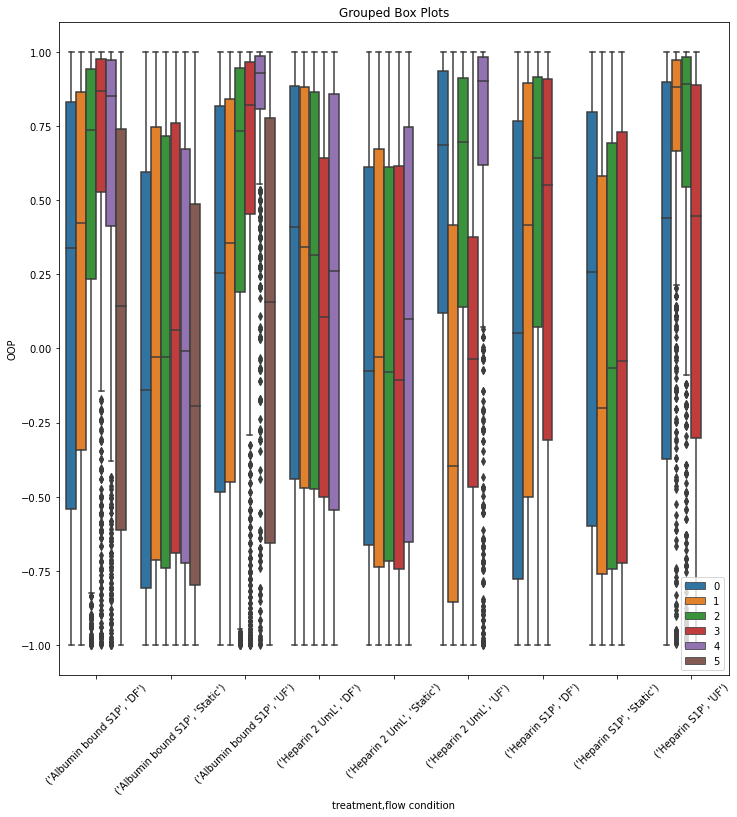

In [53]:
plt.figure(figsize = [12,12])
ax = sns.boxplot(x='name', y='Value', hue='Replicate', data=df)
# Customize the plot
plt.xlabel('treatment,flow condition')
plt.ylabel('OOP')
plt.title('Grouped Box Plots')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);
plt.legend(loc='lower right')


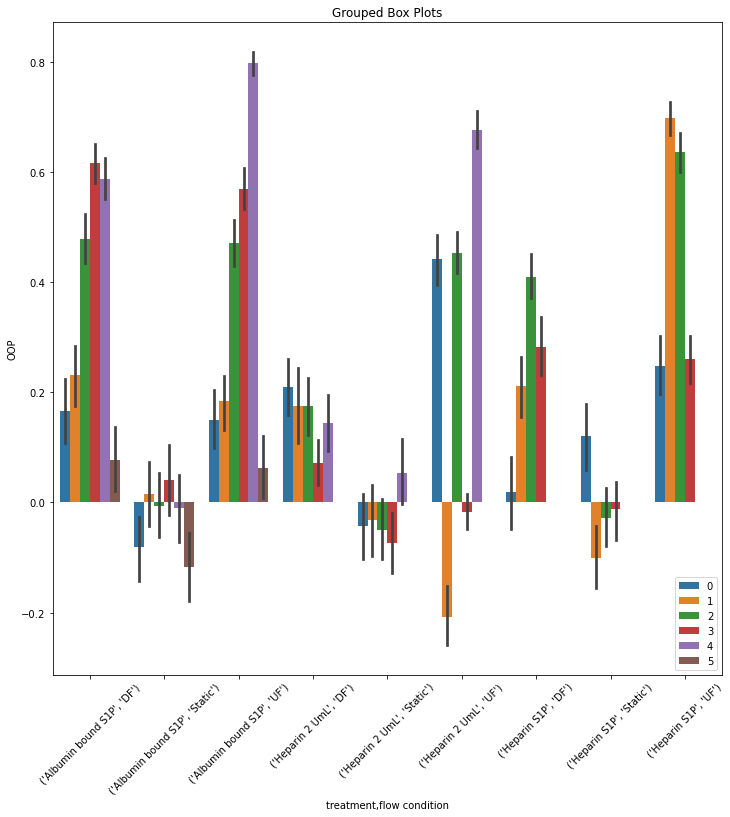

In [55]:
plt.figure(figsize = [12,12])
ax = sns.barplot(x='name', y='Value', hue='Replicate', data=df)
# Customize the plot
plt.xlabel('treatment,flow condition')
plt.ylabel('OOP')
plt.title('Grouped Box Plots')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);
plt.legend(loc='lower right')


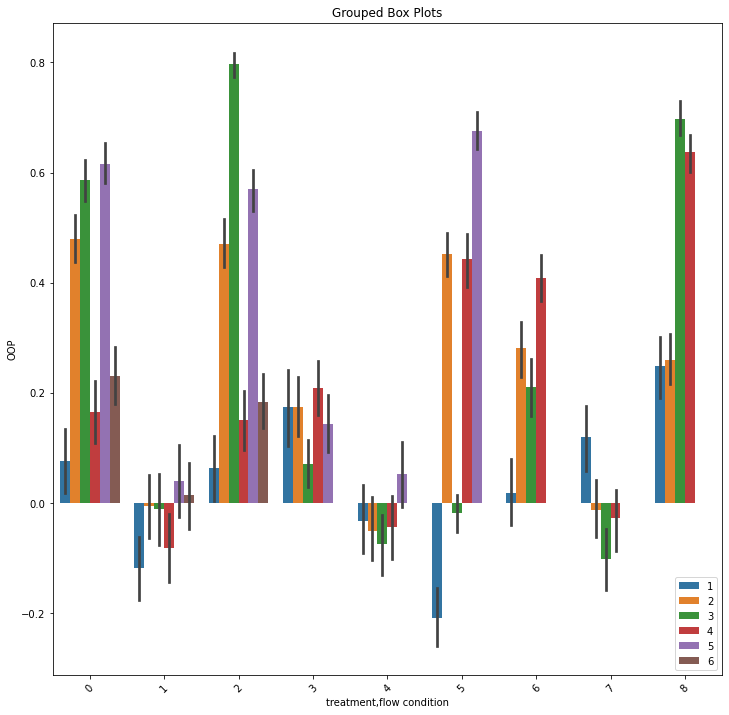

In [56]:
elong_df = master_df[master_df['elong2']==True]


plt.figure(figsize = [12,12])
ax = sns.barplot(x='group', y='oop_bar', hue='replicate', data=elong_df)
# Customize the plot
plt.xlabel('treatment,flow condition')
plt.ylabel('OOP')
plt.title('Grouped Box Plots')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);
plt.legend(loc='lower right')


In [ ]:
(master_df['group']==5) & master_df


In [58]:
g1_r1_dict = meta_data_df[(meta_data_df['group']==5) & (meta_data_df['replicate']==1)]
g1_r1_dict



exp_num                                  file_name  \
4        4  HCAEC P8_12 hr UF_Heparin 2 UmL_13023.czi   

                                data_path      treatment flow   time cell_age  \
4  Cell Alignment/Heparin Treated/1.30.23  Heparin 2 UmL   UF  12 hr       P8   

    date  group  replicate  
4  13023      5          1

In [61]:
params = {'thresh_block' : 101,
             'err_dil_disk' : 3,
             'max_cell_size' : 1500,
             'min_cell_size' : 100
         }
#meta_data_df = pd.read_csv('Ron_Cell_Alignment_metadata_4_30_23.csv')

exp_data,c_img,stack_img = process_file_v2(g1_r1_dict.iloc[0].to_dict(),params,return_images=True)

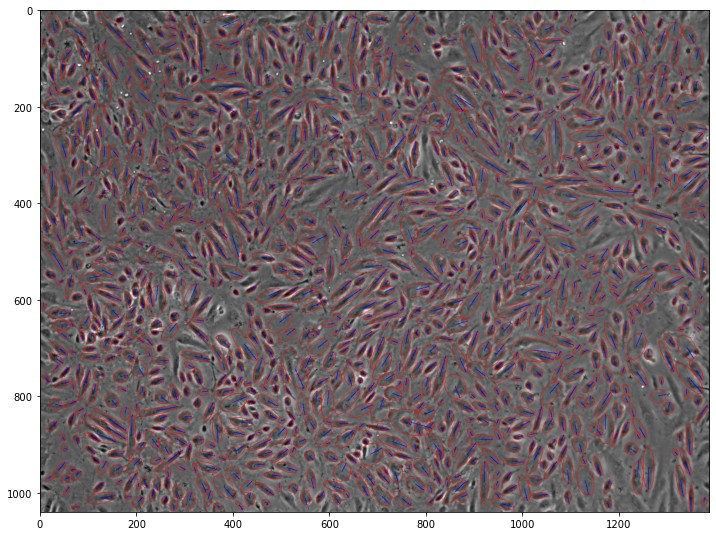

In [62]:
plt.figure(figsize = [12,12])
plt.imshow(c_img)

   exp_num                                    file_name  \
8        8  HCAEC_12 hr UF_P7_Heparin 2 UmL_1_21523.czi   

                                data_path      treatment flow   time cell_age  \
8  Cell Alignment/Heparin Treated/2.15.23  Heparin 2 UmL   UF  12 hr       P7   

    date  group  replicate  
8  21523      5          2  


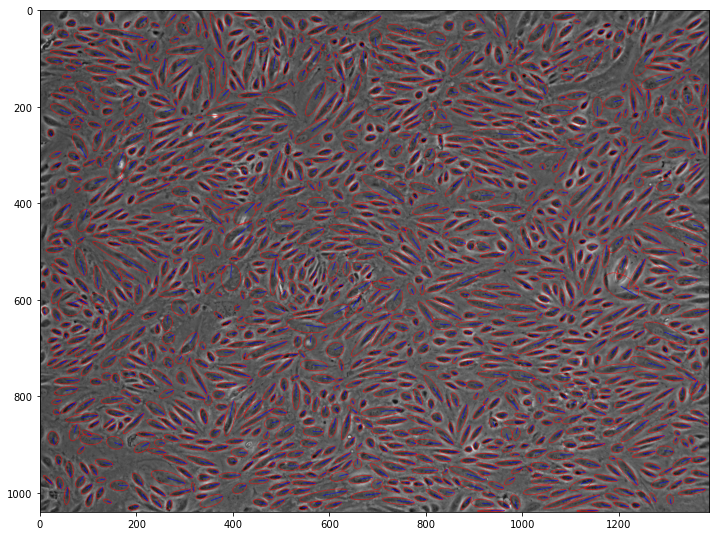

In [63]:
g1_r2_dict = meta_data_df[(meta_data_df['group']==5) & (meta_data_df['replicate']==2)]


exp_data,c_img,stack_img = process_file_v2(g1_r2_dict.iloc[0].to_dict(),params,return_images=True)
print(g1_r2_dict)

plt.figure(figsize = [12,12])
plt.imshow(c_img)

   exp_num                                    file_name  \
8        8  HCAEC_12 hr UF_P7_Heparin 2 UmL_1_21523.czi   

                                data_path      treatment flow   time cell_age  \
8  Cell Alignment/Heparin Treated/2.15.23  Heparin 2 UmL   UF  12 hr       P7   

    date  group  replicate  
8  21523      5          2  


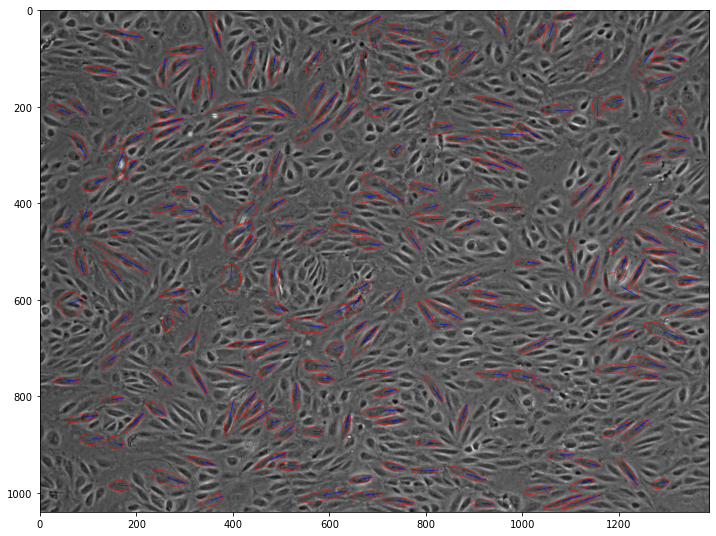

In [64]:
g1_r2_dict = meta_data_df[(meta_data_df['group']==5) & (meta_data_df['replicate']==2)]
params = {'thresh_block' : 101,
             'err_dil_disk' : 3,
             'max_cell_size' : 1500,
             'min_cell_size' : 500
         }

exp_data,c_img,stack_img = process_file_v2(g1_r2_dict.iloc[0].to_dict(),params,return_images=True)
print(g1_r2_dict)

plt.figure(figsize = [12,12])
plt.imshow(c_img)

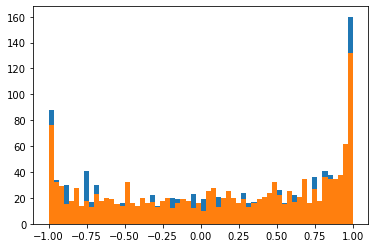

In [52]:
plt.hist(hep_DF_12['oop_zero'],bins = 60);
plt.hist(hep_DF_12['oop_bar'],bins = 60);

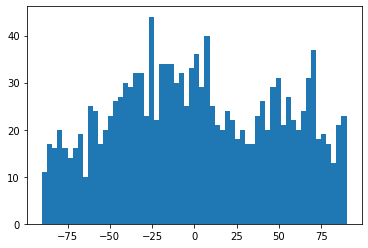

In [49]:
plt.hist(hep_DF_12['rot90'],bins = 60);

In [59]:

s1p_DF_12 = master_df[(master_df['condition'] == 'Albumin bound S1P') & 
          (master_df['elong2'] == True) & 
          (master_df['time']=='12 hr') & 
          (master_df['flow']=='DF')]

s1p_DF_12['exp_num'].unique()

array([10, 15, 19, 23])

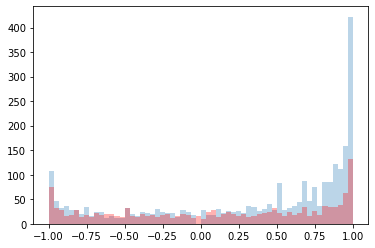

In [61]:
plt.hist(s1p_DF_12['oop_zero'],bins = 60,alpha = 0.3);
#plt.hist(s1p_DF_12['oop_bar'],bins = 60,alpha = 0.3,color = 'red');
plt.hist(hep_DF_12['oop_bar'],bins = 60,alpha = 0.3,color = 'red');


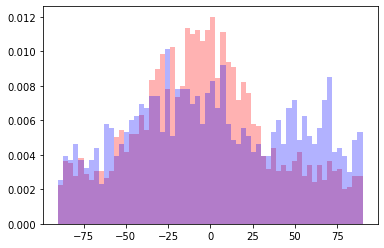

In [60]:
plt.hist(s1p_DF_12['rot90'],bins = 60,alpha = 0.3,color = 'red',density = True);
plt.hist(hep_DF_12['rot90'],bins = 60,alpha = 0.3,color = 'blue',density = True);


In [62]:
import seaborn as sns

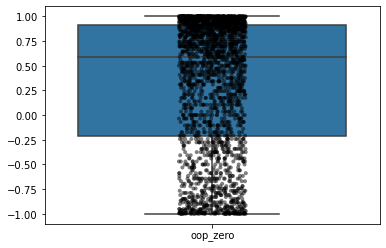

In [64]:



fig, ax = plt.subplots()
sns.boxplot(data=s1p_DF_12[['oop_zero']], ax=ax)
sns.stripplot(data=s1p_DF_12[['oop_zero']], color="black", jitter=True, size=4, alpha=0.5, ax=ax)

plt.show()

In [29]:
master_df.to_csv('Ron_Cell_Alignment_masterDF_3_13_23.csv', index=False)

In [ ]:
master_df['flow']

In [30]:
meta_data_df['condition'].unique()

array(['heparin 2 UmL', 'Albumin bound S1P'], dtype=object)

In [31]:
meta_data_df['flow'].unique()

array(['DF', 'Static', 'UF'], dtype=object)

In [5]:
f1_data = process_file(f1_params)

f2_data = process_file(f2_params)

f3_data = process_file(f3_params)

f4_data = process_file(f4_params)

f5_data = process_file(f5_params)

f6_data = process_file(f6_params)

f7_data = process_file(f7_params)

In [6]:
masterdf = pd.concat((f1_data[0],f2_data[0],f3_data[0],f4_data[0], f5_data[0], f6_data[0], f7_data[0]),axis = 0,ignore_index = True)
masterdf

f_name  \
0     HCAEC_0 hr Static_P7_heparin 2 UmL_1_21523.czi   
1     HCAEC_0 hr Static_P7_heparin 2 UmL_1_21523.czi   
2     HCAEC_0 hr Static_P7_heparin 2 UmL_1_21523.czi   
3     HCAEC_0 hr Static_P7_heparin 2 UmL_1_21523.czi   
4     HCAEC_0 hr Static_P7_heparin 2 UmL_1_21523.czi   
...                                              ...   
8557   HCAEC_12 hr UF_P6_Albumin bound S1P_22223.czi   
8558   HCAEC_12 hr UF_P6_Albumin bound S1P_22223.czi   
8559   HCAEC_12 hr UF_P6_Albumin bound S1P_22223.czi   
8560   HCAEC_12 hr UF_P6_Albumin bound S1P_22223.czi   
8561   HCAEC_12 hr UF_P6_Albumin bound S1P_22223.czi   

                       condition  obj_num  area  \
0                    0 hr Static       41   597   
1                    0 hr Static       42   161   
2                    0 hr Static       43   244   
3                    0 hr Static       48   121   
4                    0 hr Static       49   280   
...                          ...      ...   ...   
8557  12 hr UF Albumin bound S1P     2015   288   
8558  12 hr UF Albumin bound S1P     2016   205   
8559  12 hr UF Albumin bound S1P     2018   200   
8560  12 hr UF Albumin bound S1P     2020   206   
8561  12 hr UF Albumin bound S1P     2021   206   

                                          ellipse Tuple  \
0     ((1341.1302490234375, 21.448139190673828), (23...   
1     ((455.17572021484375, 11.001180648803711), (10...   
2     ((556.6180419921875, 14.784433364868164), (10....   
3     ((475.2391357421875, 13.151412010192871), (8.8...   
4     ((521.7542114257812, 18.2967472076416), (11.48...   
...                                                 ...   
8557  ((899.8606567382812, 1024.0240478515625), (13....   
8558  ((1236.1138916015625, 1024.011962890625), (13....   
8559  ((1153.4603271484375, 1025.7515869140625), (10...   
8560  ((640.2052612304688, 1027.33740234375), (14.56...   
8561  ((1112.636962890625, 1026.5819091796875), (13....   

                                        center     length     ratio  rot90  
0     (1341.1302490234375, 21.448139190673828)  36.821877  1.537459    -44  
1     (455.17572021484375, 11.001180648803711)  17.206974  1.589186     48  
2      (556.6180419921875, 14.784433364868164)  26.722052  2.552557    -44  
3      (475.2391357421875, 13.151412010192871)  16.652533  1.880130    -73  
4        (521.7542114257812, 18.2967472076416)  31.598787  2.750827    -46  
...                                        ...        ...       ...    ...  
8557   (899.8606567382812, 1024.0240478515625)  26.514540  2.017705     16  
8558   (1236.1138916015625, 1024.011962890625)  17.736702  1.283602    -18  
8559  (1153.4603271484375, 1025.7515869140625)  22.553480  2.161797    -23  
8560     (640.2052612304688, 1027.33740234375)  16.403860  1.126253     54  
8561   (1112.636962890625, 1026.5819091796875)  17.974152  1.361253     -2  

[8562 rows x 9 columns]

## View intermediate and output images to ensure processing methods work as expected

##### this one is mad slow because of the randomize labels function. not a huge deal, but could go back and optimize that function with a LUT mapping

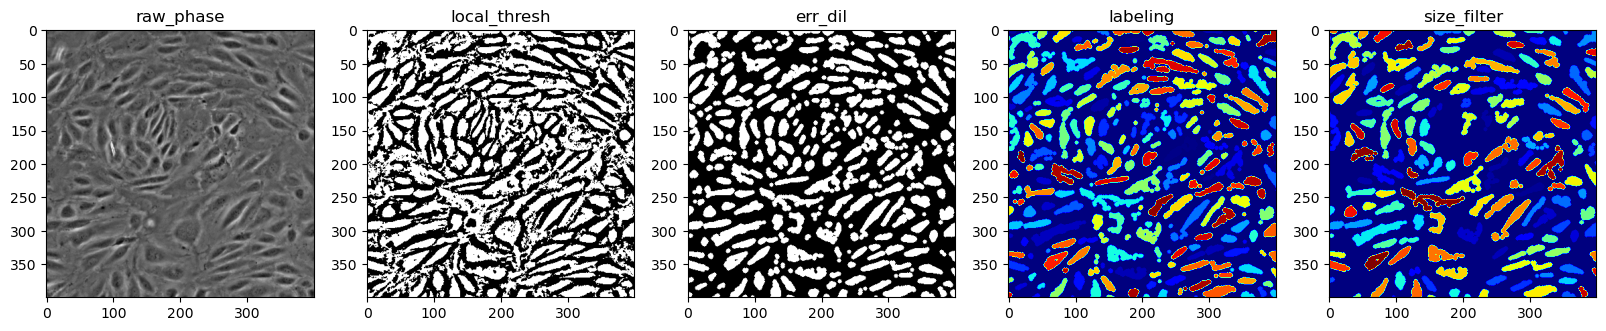

In [8]:
#plot_large(f2_data[2][6])
#plt.imshow(f2_data[2][6][400:800,400:800])

titles = ['raw_phase','local_thresh','err_dil','labeling','size_filter']
fig, ax = plt.subplots(1, 5,figsize = (20,5))
for i in range(5):
    if i >2:
        ax[i].imshow(randomize_labels(f6_data[2][i][400:800,400:800]),'jet')
        ax[i].set_title(titles[i])
    else:
        ax[i].imshow(f6_data[2][i][400:800,400:800],'gray')
        ax[i].set_title(titles[i])

#     ax[i].imshow(f2_data[2])
#     ax[i].set_title('Flow')
#     ax[i].imshow(f2_data[2])
#     ax[i].set_title('Flow')
#     ax[i].imshow(f2_data[2])
#     ax[i].set_title('Flow')
# ax[4].imshow(f2_data[1])
# ax[1].set_title('Flow')

Text(0.5, 1.0, '12 hr UF Albumin bound S1P')

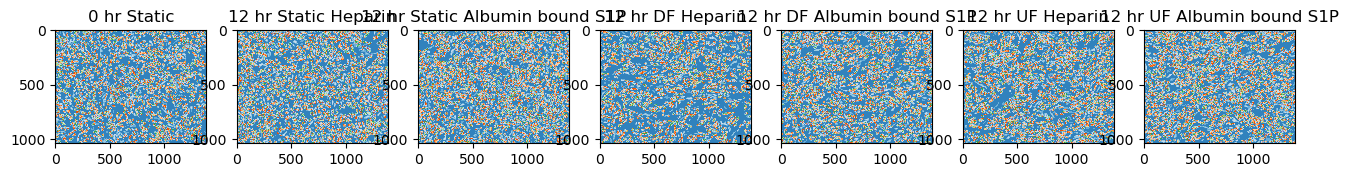

In [34]:
fig, ax = plt.subplots(1, 7,figsize = (16,8))
ax[0].imshow(randomize_labels(f1_data[2][4]),'tab20c')
ax[0].set_title('0 hr Static')

ax[1].imshow(randomize_labels(f2_data[2][4]),'tab20c')
ax[1].set_title('12 hr Static Heparin')

ax[2].imshow(randomize_labels(f3_data[2][4]),'tab20c')
ax[2].set_title('12 hr Static Albumin bound S1P')

ax[3].imshow(randomize_labels(f4_data[2][4]),'tab20c')
ax[3].set_title('12 hr DF Heparin')

ax[4].imshow(randomize_labels(f5_data[2][4]),'tab20c')
ax[4].set_title('12 hr DF Albumin bound S1P')

ax[5].imshow(randomize_labels(f6_data[2][4]),'tab20c')
ax[5].set_title('12 hr UF Heparin')

ax[6].imshow(randomize_labels(f7_data[2][4]),'tab20c')
ax[6].set_title('12 hr UF Albumin bound S1P')

#plot_large(randomize_labels(im_lab_accept),'jet')
#plt.imshow(randomize_labels(im_lab_accept),'jet')

# plt.figure(figsize = [24,16])
# plt.title('All accepted objects. colored for differentiation')
# plt.subplot(1,2,1)
# plt.imshow(randomize_labels(f1_data[2][4]),'tab20c')
# plt.subplot(1,2,2)
# plt.imshow(randomize_labels(f2_data[2][4]),'tab20c')

Text(0.5, 1.0, '12 hr UF Heparin')

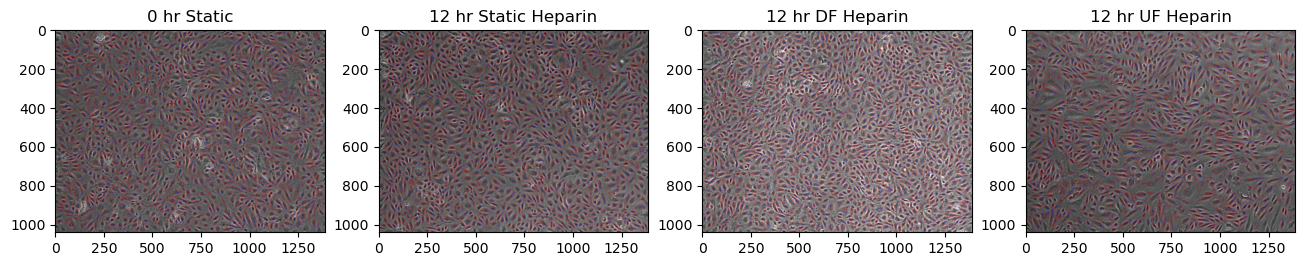

In [31]:
fig, ax = plt.subplots(1, 4,figsize = (16,8))
ax[0].imshow(f1_data[1])
ax[0].set_title('0 hr Static')

ax[1].imshow(f2_data[1])
ax[1].set_title('12 hr Static Heparin')

ax[2].imshow(f3_data[1])
ax[2].set_title('12 hr DF Heparin')

ax[3].imshow(f4_data[1])
ax[3].set_title('12 hr UF Heparin')

#fig.suptitle("Phase image with fit ellipses an cell orientation pointer");


# plt.figure(figsize = [24,14])
# plt.title('All accepted objects. colored for differentiation')
# plt.subplot(1,2,1)
# plt.imshow(f1_data[1])
# plt.subplot(1,2,2)
# plt.imshow(f2_data[1])

## Plot the analysis results from different experiments

ConversionError: Failed to convert value(s) to axis units: array([((1341.1302490234375, 21.448139190673828), (23.949825286865234, 36.821876525878906), 45.76526641845703),
       ((455.17572021484375, 11.001180648803711), (10.827537536621094, 17.206974029541016), 138.0460662841797),
       ((556.6180419921875, 14.784433364868164), (10.46873664855957, 26.7220516204834), 45.62098693847656),
       ...,
       ((885.2427978515625, 1025.8271484375), (15.208512306213379, 48.634517669677734), 81.38954162597656),
       ((657.23681640625, 1028.552734375), (13.323182106018066, 16.249326705932617), 171.35865783691406),
       ((690.4848022460938, 1027.5482177734375), (14.50271224975586, 15.879849433898926), 140.85440063476562)],
      dtype=object)

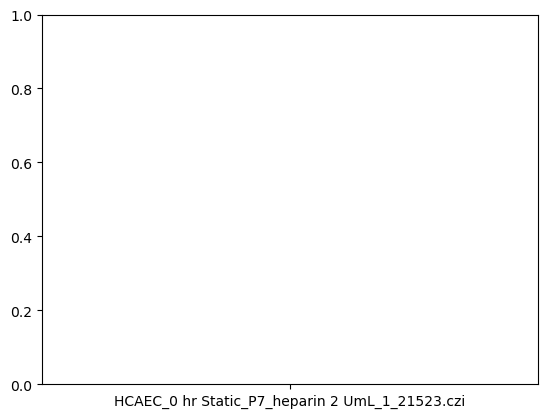

In [38]:
Zero_Hr = masterdf[masterdf['condition'] == '0 hr Static']
#Twelve_Hr_S_Hep = masterdf[masterdf['condition'] == '12 hour Static Heparin']
#Twelve_Hr_S_S1P = masterdf[masterdf['condition'] == '12 hour Static Albumin bound S1P']
#Twelve_Hr_DF_Hep = masterdf[masterdf['condition'] == '12 hr DF Heparin']
#Twelve_Hr_DF_S1P = masterdf[masterdf['condition'] == '12 hr Albumin bound S1P']
#Twelve_Hr_UF_HS = masterdf[masterdf['condition'] == '12 hr UF Heparin']
#Twelve_Hr_UF_S1P = masterdf[masterdf['condition'] == '12 hr Albumin bound S1P']

plt.hist(Zero_Hr,bins = 50,alpha = 0.1,density = True,color = 'k');
plt.hist(Twelve_Hr_S_Hep,bins = 50,alpha = 0.1,density = True,color = 'm');
plt.hist(Twelve_Hr_S_S1P,bins = 50,alpha = 0.1,density = True,color = 'r');
plt.hist(Twelve_Hr_DF_Hep,bins = 50,alpha = 0.1,density = True,color = 'g');
plt.hist(Twelve_Hr_DF_S1P,bins = 50,alpha = 0.1,density = True,color = 'c');
plt.hist(Twelve_Hr_UF_HS,bins = 50,alpha = 0.1,density = True,color = 'y');
plt.hist(Twelve_Hr_UF_S1P,bins = 50,alpha = 0.1,density = True,color = 'b');

plt.title('cell orientation (frequency/total cell)')
plt.xlabel('angle')
plt.ylabel('density');
plt.legend(['0 hr Static', '12 hr Static heparin',' 12 hr Static S1P', '12 hr DF Heparin','12 hr DF S1P', '12 hr UF Heparin', '12 hr UF S1P'])

In [9]:
import seaborn as sns

/Users/ronmitra/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/ronmitra/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/ronmitra/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with si

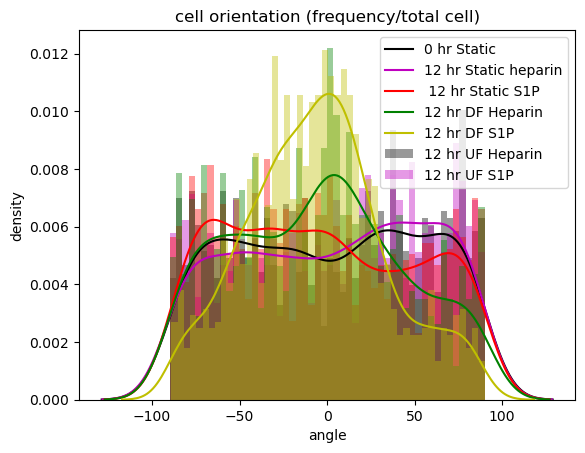

In [10]:
Zero_Hr = masterdf[masterdf['condition'] == '0 hr Static']['rot90']
Twelve_Hr_S_Hep = masterdf[masterdf['condition'] == '12 hour Static Heparin']['rot90']
Twelve_Hr_S_S1P = masterdf[masterdf['condition'] == '12 hour Static Albumin bound S1P']['rot90']
Twelve_Hr_DF_Hep = masterdf[masterdf['condition'] == '12 hr DF Heparin']['rot90']
Twelve_Hr_DF_S1P = masterdf[masterdf['condition'] == '12 hr Albumin bound S1P']['rot90']
Twelve_Hr_UF_HS = masterdf[masterdf['condition'] == '12 hr UF Heparin']['rot90']
Twelve_Hr_UF_S1P = masterdf[masterdf['condition'] == '12 hr Albumin bound S1P']['rot90']

sns.distplot(Zero_Hr,bins = 50, color = 'k');
sns.distplot(Twelve_Hr_S_Hep,bins = 50, color = 'm');
sns.distplot(Twelve_Hr_S_S1P,bins = 50, color = 'r');
sns.distplot(Twelve_Hr_DF_Hep,bins = 50, color = 'g');
sns.distplot(Twelve_Hr_DF_S1P,bins = 50, color = 'c');
sns.distplot(Twelve_Hr_UF_HS,bins = 50, color = 'y');
sns.distplot(Twelve_Hr_UF_S1P,bins = 50, color = 'b');

#Zero_Hr = masterdf[masterdf['condition'] == '0 hr Static']['rot90']
#Twelve_Hr_S = masterdf[masterdf['condition'] == '12 hour Static Heparin']['rot90']
#Twelve_Hr_DF = masterdf[masterdf['condition'] == '12 hr DF Heparin']['rot90']
#Twelve_Hr_UF = masterdf[masterdf['condition'] == '12 hr UF Heparin']['rot90']

#flow = masterdf[masterdf['condition'] == '12 hr DF Heparin']['rot90']
#noF = masterdf[masterdf['condition'] == '12 hr UF Heparin']['rot90']
#sns.distplot(Zero_Hr,bins = 50,color = 'k'); #alpha = 0.5,,density = True,
#sns.distplot(Twelve_Hr_S,bins = 50,color = 'b'); #alpha = 0.5,
#plt.hist(noF,bins = 50,alpha = 0.5,density = True,color = 'r');
#sns.distplot(Twelve_Hr_DF,bins = 50,color = 'r');
#sns.distplot(Twelve_Hr_UF,bins = 50,color = 'g');
plt.title('cell orientation (frequency/total cell)')
plt.xlabel('angle')
plt.ylabel('density');
plt.legend(['0 hr Static', '12 hr Static heparin',' 12 hr Static S1P', '12 hr DF Heparin',
            '12 hr DF S1P', '12 hr UF Heparin', '12 hr UF S1P'])
#plt.savefig('cell-orientation.png')

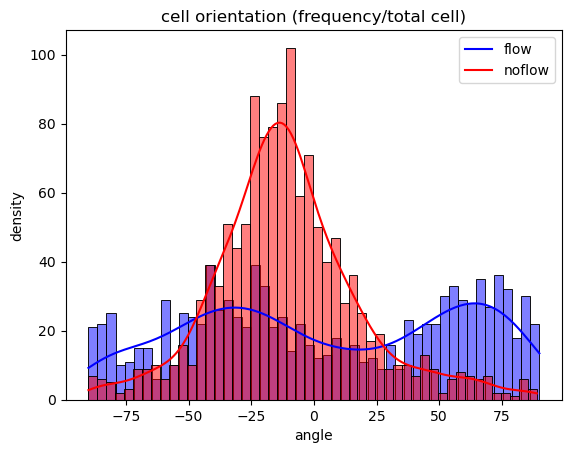

In [139]:
flow = masterdf[masterdf['condition'] == '12 hr DF Heparin']['rot90']
noF = masterdf[masterdf['condition'] == '12 hr UF Heparin']['rot90']
sns.histplot(flow,bins = 50,color = 'b',kde = True); #alpha = 0.5,,density = True,
sns.histplot(noF,bins = 50,color = 'r',kde = True); #alpha = 0.5,
#plt.hist(noF,bins = 50,alpha = 0.5,density = True,color = 'r');
plt.title('cell orientation (frequency/total cell)')
plt.xlabel('angle')
plt.ylabel('density');
plt.legend(['flow', 'noflow'])

In [17]:
masterdf['condition'] == '12 hour Static Heparin')

1246

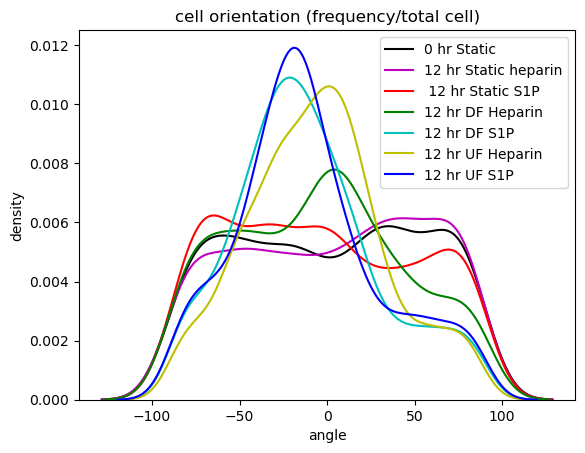

In [25]:
Zero_Hr = masterdf[masterdf['condition'] == '0 hr Static']['rot90']
Twelve_Hr_S_Hep = masterdf[masterdf['condition'] == '12 hour Static Heparin']['rot90']
Twelve_Hr_S_S1P = masterdf[masterdf['condition'] == '12 hour Static Albumin bound S1P']['rot90']
Twelve_Hr_DF_Hep = masterdf[masterdf['condition'] == '12 hr DF Heparin']['rot90']
Twelve_Hr_DF_S1P = masterdf[masterdf['condition'] == '12 hr DF Albumin bound S1P']['rot90']
Twelve_Hr_UF_HS = masterdf[masterdf['condition'] == '12 hr UF Heparin']['rot90']
Twelve_Hr_UF_S1P = masterdf[masterdf['condition'] == '12 hr UF Albumin bound S1P']['rot90']

sns.kdeplot(Zero_Hr, color = 'k');
sns.kdeplot(Twelve_Hr_S_Hep, color = 'm');
sns.kdeplot(Twelve_Hr_S_S1P, color = 'r');
sns.kdeplot(Twelve_Hr_DF_Hep, color = 'g');
sns.kdeplot(Twelve_Hr_DF_S1P, color = 'c');
sns.kdeplot(Twelve_Hr_UF_HS, color = 'y');
sns.kdeplot(Twelve_Hr_UF_S1P, color = 'b');


#sns.kdeplot()


#flow = masterdf[masterdf['condition'] == '12 hr DF Heparin']['rot90']
#noF = masterdf[masterdf['condition'] == '12 hr UF Heparin']['rot90']
#sns.kdeplot(Zero_Hr, color = 'k')#,bins = 50,color = 'b',kde = True); #alpha = 0.5,,density = True,
#sns.kdeplot(Twelve_Hr_S, color = 'b')#,bins = 50,color = 'r',kde = True); #alpha = 0.5,
#plt.hist(noF,bins = 50,alpha = 0.5,density = True,color = 'r');
#sns.kdeplot(Twelve_Hr_DF, color = 'r')
#sns.kdeplot(Twelve_Hr_UF, color = 'g')
plt.title('cell orientation (frequency/total cell)')
plt.xlabel('angle')
plt.ylabel('density');
plt.legend(['0 hr Static', '12 hr Static heparin',' 12 hr Static S1P', '12 hr DF Heparin',
            '12 hr DF S1P', '12 hr UF Heparin', '12 hr UF S1P'])
#plt.xlim([-90,90])

flow condition cell count: 1677
no flow condition cell count: 1579


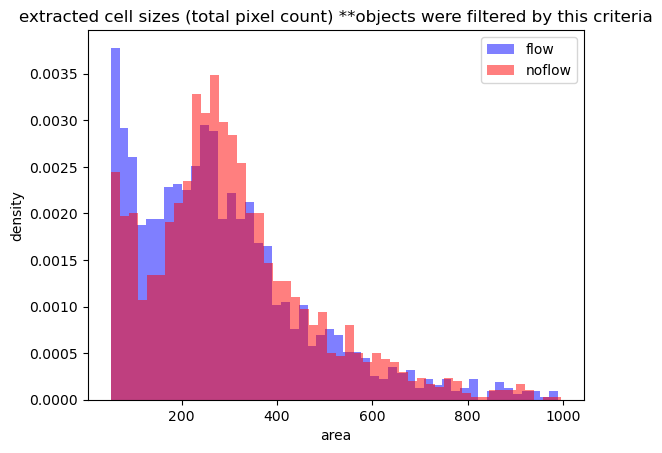

In [19]:
flowArea = masterdf[masterdf['condition'] == 'Flow1']['area']
noFArea = masterdf[masterdf['condition'] == 'noFlow1']['area']
plt.hist(flowArea,bins = 50,alpha = 0.5,density = True,color = 'b');
plt.hist(noFArea,bins = 50,alpha = 0.5,density = True,color = 'r');
plt.title('extracted cell sizes (total pixel count) **objects were filtered by this criteria')
plt.xlabel('area')
plt.ylabel('density');
plt.legend(['flow', 'noflow'])
print('flow condition cell count: {}'.format(len(flowArea)))
print('no flow condition cell count: {}'.format(len(noFArea)))

flow condition cell count: 1677
no flow condition cell count: 1579


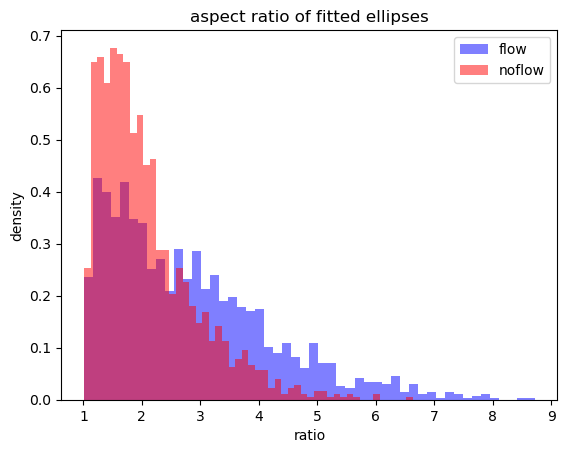

In [20]:
flowRatio = masterdf[masterdf['condition'] == 'Flow1']['ratio']
noFRatio = masterdf[masterdf['condition'] == 'noFlow1']['ratio']
plt.hist(flowRatio,bins = 50,alpha = 0.5,density = True,color = 'b');
plt.hist(noFRatio,bins = 50,alpha = 0.5,density = True,color = 'r');
plt.title('aspect ratio of fitted ellipses')
plt.xlabel('ratio')
plt.ylabel('density');
plt.legend(['flow', 'noflow'])
print('flow condition cell count: {}'.format(len(flowArea)))
print('no flow condition cell count: {}'.format(len(noFArea)))

In [19]:
np.sum(noFRatio>2)

NameError: name 'noFRatio' is not defined

flow condition cell count: 1677
no flow condition cell count: 1579


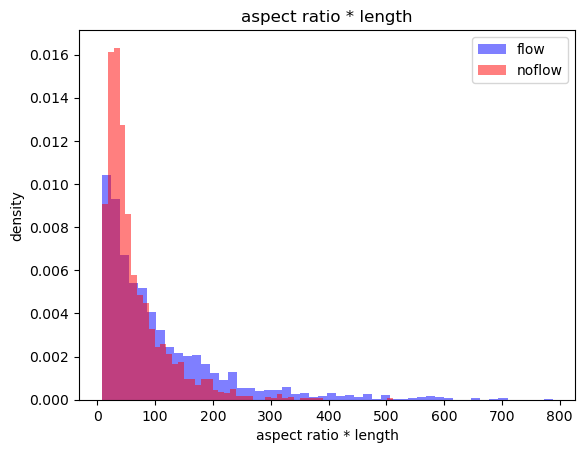

In [21]:
flowRatio = masterdf[masterdf['condition'] == 'Flow1']['ratio']
flowlength = masterdf[masterdf['condition'] == 'Flow1']['length']
flowRL = np.array(flowRatio)*np.array(flowlength)

noFRatio = masterdf[masterdf['condition'] == 'noFlow1']['ratio']
noFlength = masterdf[masterdf['condition'] == 'noFlow1']['length']
noFRL = np.array(noFRatio)*np.array(noFlength)

plt.hist(flowRL,bins = 50,alpha = 0.5,density = True,color = 'b');
plt.hist(noFRL,bins = 50,alpha = 0.5,density = True,color = 'r');
plt.title('aspect ratio * length')
plt.xlabel('aspect ratio * length')
plt.ylabel('density');
plt.legend(['flow', 'noflow'])
print('flow condition cell count: {}'.format(len(flowArea)))
print('no flow condition cell count: {}'.format(len(noFArea)))

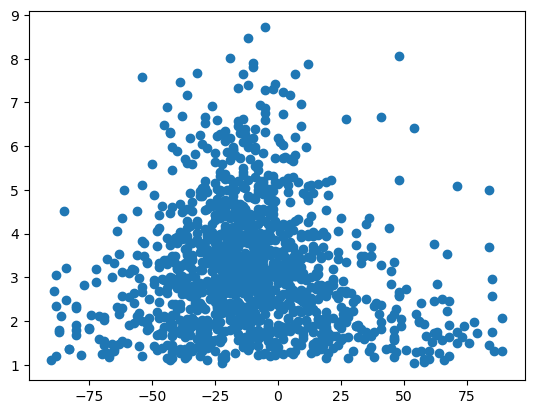

In [55]:
flowAngle = masterdf[masterdf['condition'] == 'Flow1']['rot90']
flowRatio= masterdf[masterdf['condition'] == 'Flow1']['ratio']
plt.scatter(flowAngle,flowRatio)

In [22]:
np.sum(masterdf[masterdf['condition'] == '0 hr Static']['ratio']>2)

547

In [23]:
np.sum(masterdf[masterdf['condition'] == '0 hr Static']['ratio'])

2578.1306961903083